# Main Diffusion Script
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import a_unet
except:
    !pip install a_unet


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler

from a_unet import TimeConditioningPlugin, ClassifierFreeGuidancePlugin
from a_unet.apex import XUNet, XBlock, ResnetItem as R, AttentionItem as A, CrossAttentionItem as C, ModulationItem as M, SkipCat

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 134.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 13.1 MB/s eta 0:00:00


### Config

General

In [11]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_full_v15"
training_data_name: str = "training_full_mel"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [12]:
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [13]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 5600
n_validation_samples: int = 50
batch_size: int = 128
tensor_dim: list = [batch_size, 128, 576] #B, C, H = Batch, Freq bins, Time domain

learning_rate: float = 5e-4
epochs: int = 300
restart_training: bool = True
checkpoint_freq: int = 10

### Data Loading

In [14]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-02 06:50:29,619 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_mel.npy of shape: (5906, 128, 576)
2025-06-02 06:50:30,204 - INFO - Data loaded with shape: (5906, 128, 576)


### Setup

Model Creation

In [17]:
u_net = UNetV0
u_net = DiffusionModel(
    net_t=u_net,
    in_channels=128,
    channels=[128, 256, 512, 512, 1024, 1024, 1024],
    factors=[1, 1, 2, 2, 2, 2, 2],
    items=[1, 2, 2, 2, 2, 2, 2],
    attentions=[0, 0, 0, 1, 1, 0, 0],
    attention_features=256,
    attention_heads=8,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
    dim=1
).to(device)


Model Loading

In [18]:
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-06-02 06:50:46,765 - INFO - Model diffusion_full_v15 created with ~196.7M Parameters


Initiate Trainer

In [19]:
trainer = Trainer(u_net, optimizer, scheduler, device, n_dims=1)

### Training

2025-06-02 06:51:00,429 - INFO - Training started on cuda


2025-06-02 06:51:21,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.387 Min/Max params: -2.379, 2.672


2025-06-02 06:51:21,238 - INFO - Epoch 001: Avg. Loss: 4.60068e-01 Avg. val. Loss: 5.03787e-01 Remaining Time: 01h 43min 39s LR: 4.90000e-04 


2025-06-02 06:51:39,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.367 Min/Max params: -2.380, 2.670


2025-06-02 06:51:39,622 - INFO - Epoch 002: Avg. Loss: 4.05472e-01 Avg. val. Loss: 4.88741e-01 Remaining Time: 01h 37min 18s LR: 4.80200e-04 


2025-06-02 06:52:16,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.345 Min/Max params: -2.380, 2.667


2025-06-02 06:52:16,669 - INFO - Epoch 003: Avg. Loss: 3.78226e-01 Avg. val. Loss: 3.77045e-01 Remaining Time: 02h 05min 46s LR: 4.70596e-04 


2025-06-02 06:52:39,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.344 Min/Max params: -2.379, 2.664


2025-06-02 06:52:39,379 - INFO - Epoch 004: Avg. Loss: 3.50807e-01 Avg. val. Loss: 2.88584e-01 Remaining Time: 02h 02min 01s LR: 4.61184e-04 


2025-06-02 06:52:57,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.314 Min/Max params: -2.379, 2.663


2025-06-02 06:52:57,672 - INFO - Epoch 005: Avg. Loss: 3.09555e-01 Avg. val. Loss: 3.05050e-01 Remaining Time: 01h 55min 16s LR: 4.51960e-04 


2025-06-02 06:53:19,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.252 Min/Max params: -2.379, 2.663


2025-06-02 06:53:19,996 - INFO - Epoch 006: Avg. Loss: 2.64870e-01 Avg. val. Loss: 1.76168e-01 Remaining Time: 01h 53min 58s LR: 4.42921e-04 


2025-06-02 06:53:42,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.161 Min/Max params: -2.380, 2.665


2025-06-02 06:53:42,163 - INFO - Epoch 007: Avg. Loss: 2.22774e-01 Avg. val. Loss: 2.27264e-01 Remaining Time: 01h 52min 49s LR: 4.34063e-04 


2025-06-02 06:54:04,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.162 Min/Max params: -2.380, 2.665


2025-06-02 06:54:04,536 - INFO - Epoch 008: Avg. Loss: 1.97453e-01 Avg. val. Loss: 2.11097e-01 Remaining Time: 01h 51min 59s LR: 4.25382e-04 


2025-06-02 06:54:24,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.153 Min/Max params: -2.380, 2.665


2025-06-02 06:54:24,699 - INFO - Epoch 009: Avg. Loss: 1.80374e-01 Avg. val. Loss: 1.79329e-01 Remaining Time: 01h 50min 04s LR: 4.16874e-04 


2025-06-02 06:54:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.142 Min/Max params: -2.380, 2.665


2025-06-02 06:54:48,120 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 06:54:48,127 - LIGHT_DEBUG - Normalized to range: [-1,1]


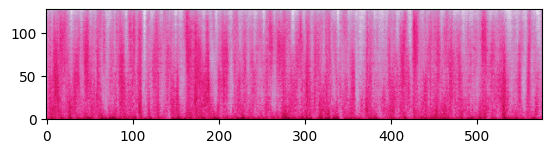

2025-06-02 06:54:48,215 - LIGHT_DEBUG - Normalized to range: [-1,1]


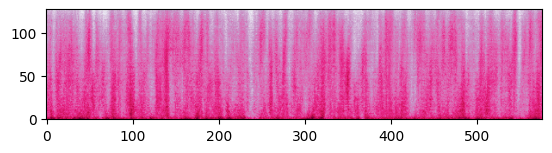

2025-06-02 06:54:48,302 - INFO - Epoch 010: Avg. Loss: 1.66874e-01 Avg. val. Loss: 1.86107e-01 Remaining Time: 01h 50min 07s LR: 4.08536e-04 
2025-06-02 06:54:50,595 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_010.pth


2025-06-02 06:55:15,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.131 Min/Max params: -2.380, 2.665


2025-06-02 06:55:15,412 - INFO - Epoch 011: Avg. Loss: 1.58071e-01 Avg. val. Loss: 1.91857e-01 Remaining Time: 01h 50min 38s LR: 4.00366e-04 


2025-06-02 06:55:33,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.117 Min/Max params: -2.379, 2.665


2025-06-02 06:55:33,396 - INFO - Epoch 012: Avg. Loss: 1.52104e-01 Avg. val. Loss: 1.42455e-01 Remaining Time: 01h 48min 15s LR: 3.92358e-04 


2025-06-02 06:55:54,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.379, 2.665


2025-06-02 06:55:54,817 - INFO - Epoch 013: Avg. Loss: 1.44226e-01 Avg. val. Loss: 1.66276e-01 Remaining Time: 01h 47min 28s LR: 3.84511e-04 


2025-06-02 06:56:16,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.110 Min/Max params: -2.380, 2.665


2025-06-02 06:56:17,045 - INFO - Epoch 014: Avg. Loss: 1.38985e-01 Avg. val. Loss: 1.64838e-01 Remaining Time: 01h 47min 00s LR: 3.76821e-04 


2025-06-02 06:56:37,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.121 Min/Max params: -2.379, 2.665


2025-06-02 06:56:37,768 - INFO - Epoch 015: Avg. Loss: 1.35732e-01 Avg. val. Loss: 1.14064e-01 Remaining Time: 01h 46min 05s LR: 3.69285e-04 


2025-06-02 06:56:59,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.126 Min/Max params: -2.379, 2.665


2025-06-02 06:56:59,831 - INFO - Epoch 016: Avg. Loss: 1.37599e-01 Avg. val. Loss: 1.20470e-01 Remaining Time: 01h 45min 38s LR: 3.61899e-04 


2025-06-02 06:57:23,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.123 Min/Max params: -2.379, 2.665


2025-06-02 06:57:23,993 - INFO - Epoch 017: Avg. Loss: 1.32544e-01 Avg. val. Loss: 1.86139e-01 Remaining Time: 01h 45min 46s LR: 3.54661e-04 


2025-06-02 06:57:44,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.127 Min/Max params: -2.379, 2.664


2025-06-02 06:57:44,919 - INFO - Epoch 018: Avg. Loss: 1.32073e-01 Avg. val. Loss: 1.32551e-01 Remaining Time: 01h 45min 00s LR: 3.47568e-04 


2025-06-02 06:58:07,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.115 Min/Max params: -2.379, 2.665


2025-06-02 06:58:07,428 - INFO - Epoch 019: Avg. Loss: 1.24963e-01 Avg. val. Loss: 1.39636e-01 Remaining Time: 01h 44min 40s LR: 3.40616e-04 


2025-06-02 06:58:25,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.104 Min/Max params: -2.379, 2.664


2025-06-02 06:58:25,761 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 06:58:25,767 - LIGHT_DEBUG - Normalized to range: [-1,1]


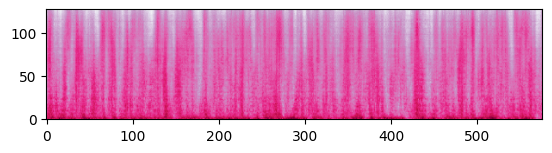

2025-06-02 06:58:25,868 - LIGHT_DEBUG - Normalized to range: [-1,1]


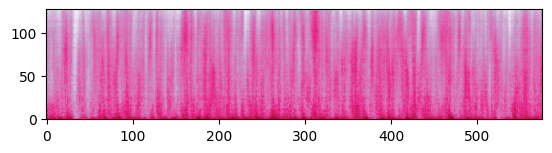

2025-06-02 06:58:25,957 - INFO - Epoch 020: Avg. Loss: 1.26927e-01 Avg. val. Loss: 1.49246e-01 Remaining Time: 01h 43min 24s LR: 3.33804e-04 
2025-06-02 06:58:27,960 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_010.pth deleted
2025-06-02 06:58:27,961 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_020.pth


2025-06-02 06:58:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.128 Min/Max params: -2.378, 2.664


2025-06-02 06:58:47,480 - INFO - Epoch 021: Avg. Loss: 1.27855e-01 Avg. val. Loss: 1.53724e-01 Remaining Time: 01h 42min 27s LR: 3.27128e-04 


2025-06-02 06:59:07,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.124 Min/Max params: -2.378, 2.664


2025-06-02 06:59:07,428 - INFO - Epoch 022: Avg. Loss: 1.28766e-01 Avg. val. Loss: 1.65445e-01 Remaining Time: 01h 41min 39s LR: 3.20585e-04 


2025-06-02 06:59:28,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.110 Min/Max params: -2.378, 2.664


2025-06-02 06:59:28,399 - INFO - Epoch 023: Avg. Loss: 1.24163e-01 Avg. val. Loss: 1.44156e-01 Remaining Time: 01h 41min 05s LR: 3.14174e-04 


2025-06-02 06:59:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.111 Min/Max params: -2.378, 2.663


2025-06-02 06:59:47,765 - INFO - Epoch 024: Avg. Loss: 1.24350e-01 Avg. val. Loss: 1.34469e-01 Remaining Time: 01h 40min 14s LR: 3.07890e-04 


2025-06-02 07:00:10,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.109 Min/Max params: -2.378, 2.663


2025-06-02 07:00:10,638 - INFO - Epoch 025: Avg. Loss: 1.25267e-01 Avg. val. Loss: 1.49063e-01 Remaining Time: 01h 40min 04s LR: 3.01732e-04 


2025-06-02 07:00:38,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.123 Min/Max params: -2.378, 2.663


2025-06-02 07:00:38,447 - INFO - Epoch 026: Avg. Loss: 1.23928e-01 Avg. val. Loss: 1.10452e-01 Remaining Time: 01h 40min 45s LR: 2.95698e-04 


2025-06-02 07:01:07,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.109 Min/Max params: -2.377, 2.663


2025-06-02 07:01:07,679 - INFO - Epoch 027: Avg. Loss: 1.23847e-01 Avg. val. Loss: 9.68156e-02 Remaining Time: 01h 41min 36s LR: 2.89784e-04 


2025-06-02 07:01:26,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.126 Min/Max params: -2.377, 2.662


2025-06-02 07:01:27,036 - INFO - Epoch 028: Avg. Loss: 1.20243e-01 Avg. val. Loss: 1.35423e-01 Remaining Time: 01h 40min 44s LR: 2.83988e-04 


2025-06-02 07:01:51,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.092 Min/Max params: -2.377, 2.663


2025-06-02 07:01:52,003 - INFO - Epoch 029: Avg. Loss: 1.21443e-01 Avg. val. Loss: 1.60046e-01 Remaining Time: 01h 40min 48s LR: 2.78308e-04 


2025-06-02 07:02:10,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.120 Min/Max params: -2.377, 2.662


2025-06-02 07:02:10,513 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:02:10,520 - LIGHT_DEBUG - Normalized to range: [-1,1]


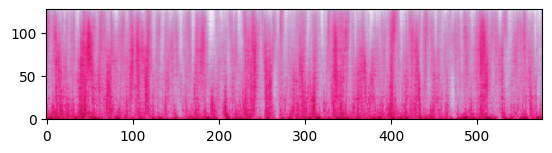

2025-06-02 07:02:10,610 - LIGHT_DEBUG - Normalized to range: [-1,1]


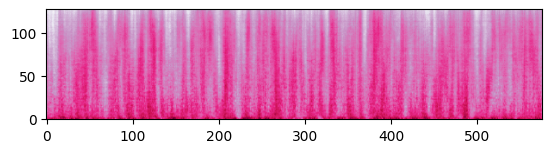

2025-06-02 07:02:10,698 - INFO - Epoch 030: Avg. Loss: 1.21366e-01 Avg. val. Loss: 1.39164e-01 Remaining Time: 01h 39min 53s LR: 2.72742e-04 
2025-06-02 07:02:12,612 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_020.pth deleted
2025-06-02 07:02:12,613 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_030.pth


2025-06-02 07:02:39,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.108 Min/Max params: -2.377, 2.662


2025-06-02 07:02:39,988 - INFO - Epoch 031: Avg. Loss: 1.19022e-01 Avg. val. Loss: 1.62561e-01 Remaining Time: 01h 40min 16s LR: 2.67287e-04 


2025-06-02 07:03:10,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.123 Min/Max params: -2.377, 2.662


2025-06-02 07:03:11,305 - INFO - Epoch 032: Avg. Loss: 1.21858e-01 Avg. val. Loss: 1.56500e-01 Remaining Time: 01h 41min 08s LR: 2.61942e-04 


2025-06-02 07:03:38,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.128 Min/Max params: -2.377, 2.662


2025-06-02 07:03:38,479 - INFO - Epoch 033: Avg. Loss: 1.14353e-01 Avg. val. Loss: 1.07547e-01 Remaining Time: 01h 41min 22s LR: 2.56703e-04 


2025-06-02 07:03:56,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.095 Min/Max params: -2.377, 2.662


2025-06-02 07:03:56,966 - INFO - Epoch 034: Avg. Loss: 1.21063e-01 Avg. val. Loss: 1.48511e-01 Remaining Time: 01h 40min 26s LR: 2.51569e-04 


2025-06-02 07:04:16,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.140 Min/Max params: -2.376, 2.662


2025-06-02 07:04:16,200 - INFO - Epoch 035: Avg. Loss: 1.15242e-01 Avg. val. Loss: 8.52342e-02 Remaining Time: 01h 39min 37s LR: 2.46537e-04 


2025-06-02 07:04:43,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.095 Min/Max params: -2.376, 2.661


2025-06-02 07:04:43,297 - INFO - Epoch 036: Avg. Loss: 1.18710e-01 Avg. val. Loss: 1.24164e-01 Remaining Time: 01h 39min 48s LR: 2.41607e-04 


2025-06-02 07:05:08,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.100 Min/Max params: -2.376, 2.661


2025-06-02 07:05:09,855 - INFO - Epoch 037: Avg. Loss: 1.15493e-01 Avg. val. Loss: 1.10853e-01 Remaining Time: 01h 39min 53s LR: 2.36774e-04 


2025-06-02 07:05:30,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.091 Min/Max params: -2.376, 2.661


2025-06-02 07:05:31,095 - INFO - Epoch 038: Avg. Loss: 1.14916e-01 Avg. val. Loss: 1.37975e-01 Remaining Time: 01h 39min 19s LR: 2.32039e-04 


2025-06-02 07:06:00,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.106 Min/Max params: -2.376, 2.661


2025-06-02 07:06:00,629 - INFO - Epoch 039: Avg. Loss: 1.14988e-01 Avg. val. Loss: 1.43375e-01 Remaining Time: 01h 39min 42s LR: 2.27398e-04 


2025-06-02 07:06:20,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.129 Min/Max params: -2.376, 2.661


2025-06-02 07:06:20,955 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:06:20,961 - LIGHT_DEBUG - Normalized to range: [-1,1]


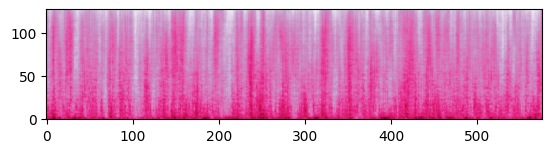

2025-06-02 07:06:21,047 - LIGHT_DEBUG - Normalized to range: [-1,1]


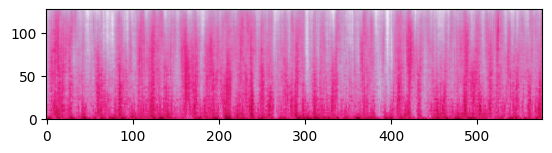

2025-06-02 07:06:21,133 - INFO - Epoch 040: Avg. Loss: 1.15500e-01 Avg. val. Loss: 1.42851e-01 Remaining Time: 01h 39min 03s LR: 2.22850e-04 
2025-06-02 07:06:23,151 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_030.pth deleted
2025-06-02 07:06:23,152 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_040.pth


2025-06-02 07:06:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.116 Min/Max params: -2.376, 2.661


2025-06-02 07:06:47,798 - INFO - Epoch 041: Avg. Loss: 1.12702e-01 Avg. val. Loss: 1.19978e-01 Remaining Time: 01h 38min 52s LR: 2.18393e-04 


2025-06-02 07:07:08,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.104 Min/Max params: -2.376, 2.661


2025-06-02 07:07:08,433 - INFO - Epoch 042: Avg. Loss: 1.14805e-01 Avg. val. Loss: 1.24063e-01 Remaining Time: 01h 38min 15s LR: 2.14025e-04 


2025-06-02 07:07:32,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.103 Min/Max params: -2.375, 2.660


2025-06-02 07:07:32,384 - INFO - Epoch 043: Avg. Loss: 1.13445e-01 Avg. val. Loss: 1.10510e-01 Remaining Time: 01h 37min 59s LR: 2.09745e-04 


2025-06-02 07:08:01,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.077 Min/Max params: -2.375, 2.660


2025-06-02 07:08:01,719 - INFO - Epoch 044: Avg. Loss: 1.11248e-01 Avg. val. Loss: 1.68633e-01 Remaining Time: 01h 38min 13s LR: 2.05550e-04 


2025-06-02 07:08:24,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.072 Min/Max params: -2.375, 2.660


2025-06-02 07:08:25,104 - INFO - Epoch 045: Avg. Loss: 1.13398e-01 Avg. val. Loss: 8.74898e-02 Remaining Time: 01h 37min 52s LR: 2.01439e-04 


2025-06-02 07:08:48,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.117 Min/Max params: -2.375, 2.660


2025-06-02 07:08:49,047 - INFO - Epoch 046: Avg. Loss: 1.10190e-01 Avg. val. Loss: 1.26251e-01 Remaining Time: 01h 37min 34s LR: 1.97410e-04 


2025-06-02 07:09:13,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.136 Min/Max params: -2.375, 2.659


2025-06-02 07:09:13,456 - INFO - Epoch 047: Avg. Loss: 1.13075e-01 Avg. val. Loss: 1.22699e-01 Remaining Time: 01h 37min 19s LR: 1.93462e-04 


2025-06-02 07:09:31,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.080 Min/Max params: -2.374, 2.659


2025-06-02 07:09:32,058 - INFO - Epoch 048: Avg. Loss: 1.13102e-01 Avg. val. Loss: 1.54621e-01 Remaining Time: 01h 36min 32s LR: 1.89593e-04 


2025-06-02 07:09:52,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.101 Min/Max params: -2.374, 2.659


2025-06-02 07:09:53,086 - INFO - Epoch 049: Avg. Loss: 1.09517e-01 Avg. val. Loss: 1.61119e-01 Remaining Time: 01h 35min 59s LR: 1.85801e-04 


2025-06-02 07:10:18,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.087 Min/Max params: -2.374, 2.659


2025-06-02 07:10:19,927 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:10:19,934 - LIGHT_DEBUG - Normalized to range: [-1,1]


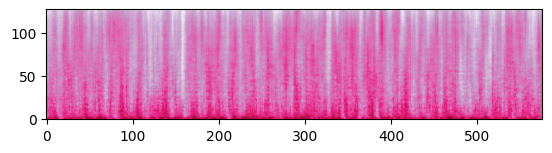

2025-06-02 07:10:20,021 - LIGHT_DEBUG - Normalized to range: [-1,1]


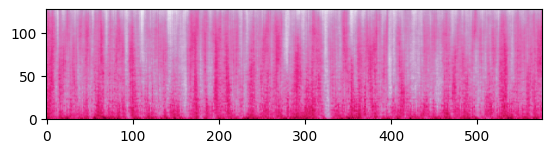

2025-06-02 07:10:20,113 - INFO - Epoch 050: Avg. Loss: 1.08287e-01 Avg. val. Loss: 1.20810e-01 Remaining Time: 01h 35min 56s LR: 1.82085e-04 
2025-06-02 07:10:22,115 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_040.pth deleted
2025-06-02 07:10:22,116 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_050.pth


2025-06-02 07:10:52,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.099 Min/Max params: -2.374, 2.659


2025-06-02 07:10:52,237 - INFO - Epoch 051: Avg. Loss: 1.09213e-01 Avg. val. Loss: 1.31792e-01 Remaining Time: 01h 36min 08s LR: 1.78443e-04 


2025-06-02 07:11:12,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.374, 2.659


2025-06-02 07:11:12,593 - INFO - Epoch 052: Avg. Loss: 1.11816e-01 Avg. val. Loss: 1.23603e-01 Remaining Time: 01h 35min 31s LR: 1.74874e-04 


2025-06-02 07:11:38,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.081 Min/Max params: -2.374, 2.659


2025-06-02 07:11:38,409 - INFO - Epoch 053: Avg. Loss: 1.08233e-01 Avg. val. Loss: 1.16636e-01 Remaining Time: 01h 35min 21s LR: 1.71377e-04 


2025-06-02 07:12:02,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.105 Min/Max params: -2.374, 2.658


2025-06-02 07:12:02,456 - INFO - Epoch 054: Avg. Loss: 1.11965e-01 Avg. val. Loss: 1.50124e-01 Remaining Time: 01h 35min 02s LR: 1.67949e-04 


2025-06-02 07:12:27,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.089 Min/Max params: -2.374, 2.659


2025-06-02 07:12:27,483 - INFO - Epoch 055: Avg. Loss: 1.12497e-01 Avg. val. Loss: 1.49860e-01 Remaining Time: 01h 34min 47s LR: 1.64590e-04 


2025-06-02 07:12:48,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.094 Min/Max params: -2.373, 2.658


2025-06-02 07:12:48,716 - INFO - Epoch 056: Avg. Loss: 1.07989e-01 Avg. val. Loss: 8.97098e-02 Remaining Time: 01h 34min 15s LR: 1.61298e-04 


2025-06-02 07:13:12,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.113 Min/Max params: -2.373, 2.658


2025-06-02 07:13:13,488 - INFO - Epoch 057: Avg. Loss: 1.08084e-01 Avg. val. Loss: 8.61370e-02 Remaining Time: 01h 33min 59s LR: 1.58072e-04 


2025-06-02 07:13:35,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.127 Min/Max params: -2.373, 2.658


2025-06-02 07:13:35,865 - INFO - Epoch 058: Avg. Loss: 1.10034e-01 Avg. val. Loss: 1.23318e-01 Remaining Time: 01h 33min 32s LR: 1.54911e-04 


2025-06-02 07:13:58,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.124 Min/Max params: -2.373, 2.658


2025-06-02 07:13:58,834 - INFO - Epoch 059: Avg. Loss: 1.11525e-01 Avg. val. Loss: 1.14869e-01 Remaining Time: 01h 33min 08s LR: 1.51813e-04 


2025-06-02 07:14:18,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.116 Min/Max params: -2.373, 2.658


2025-06-02 07:14:19,320 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:14:19,326 - LIGHT_DEBUG - Normalized to range: [-1,1]


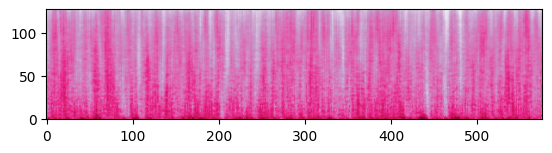

2025-06-02 07:14:19,414 - LIGHT_DEBUG - Normalized to range: [-1,1]


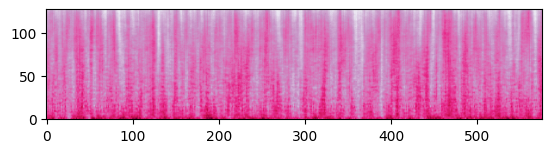

2025-06-02 07:14:19,500 - INFO - Epoch 060: Avg. Loss: 1.09283e-01 Avg. val. Loss: 9.07537e-02 Remaining Time: 01h 32min 34s LR: 1.48777e-04 
2025-06-02 07:14:21,437 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_050.pth deleted
2025-06-02 07:14:21,439 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_060.pth


2025-06-02 07:14:41,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.119 Min/Max params: -2.373, 2.658


2025-06-02 07:14:41,966 - INFO - Epoch 061: Avg. Loss: 1.06304e-01 Avg. val. Loss: 1.34165e-01 Remaining Time: 01h 32min 01s LR: 1.45801e-04 


2025-06-02 07:15:04,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.373, 2.657


2025-06-02 07:15:04,959 - INFO - Epoch 062: Avg. Loss: 1.10782e-01 Avg. val. Loss: 1.19977e-01 Remaining Time: 01h 31min 38s LR: 1.42885e-04 


2025-06-02 07:15:25,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.126 Min/Max params: -2.373, 2.657


2025-06-02 07:15:25,269 - INFO - Epoch 063: Avg. Loss: 1.09128e-01 Avg. val. Loss: 1.16228e-01 Remaining Time: 01h 31min 04s LR: 1.40027e-04 


2025-06-02 07:15:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.086 Min/Max params: -2.372, 2.657


2025-06-02 07:15:47,230 - INFO - Epoch 064: Avg. Loss: 1.09002e-01 Avg. val. Loss: 1.41870e-01 Remaining Time: 01h 30min 37s LR: 1.37227e-04 


2025-06-02 07:16:21,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.106 Min/Max params: -2.372, 2.657


2025-06-02 07:16:21,813 - INFO - Epoch 065: Avg. Loss: 1.07993e-01 Avg. val. Loss: 1.75663e-01 Remaining Time: 01h 30min 56s LR: 1.34482e-04 


2025-06-02 07:16:43,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.090 Min/Max params: -2.372, 2.657


2025-06-02 07:16:44,031 - INFO - Epoch 066: Avg. Loss: 1.07803e-01 Avg. val. Loss: 1.41685e-01 Remaining Time: 01h 30min 29s LR: 1.31793e-04 


2025-06-02 07:17:03,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.106 Min/Max params: -2.372, 2.657


2025-06-02 07:17:03,608 - INFO - Epoch 067: Avg. Loss: 1.07780e-01 Avg. val. Loss: 1.18598e-01 Remaining Time: 01h 29min 53s LR: 1.29157e-04 


2025-06-02 07:17:25,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.138 Min/Max params: -2.372, 2.657


2025-06-02 07:17:25,947 - INFO - Epoch 068: Avg. Loss: 1.09090e-01 Avg. val. Loss: 1.07191e-01 Remaining Time: 01h 29min 27s LR: 1.26574e-04 


2025-06-02 07:17:45,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.099 Min/Max params: -2.372, 2.657


2025-06-02 07:17:46,118 - INFO - Epoch 069: Avg. Loss: 1.06648e-01 Avg. val. Loss: 1.70215e-01 Remaining Time: 01h 28min 54s LR: 1.24042e-04 


2025-06-02 07:18:08,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.098 Min/Max params: -2.372, 2.657


2025-06-02 07:18:08,472 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:18:08,478 - LIGHT_DEBUG - Normalized to range: [-1,1]


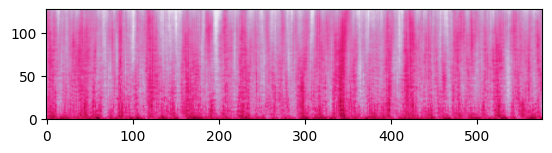

2025-06-02 07:18:08,570 - LIGHT_DEBUG - Normalized to range: [-1,1]


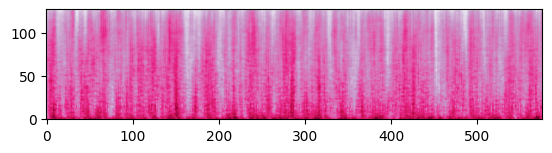

2025-06-02 07:18:08,658 - INFO - Epoch 070: Avg. Loss: 1.07430e-01 Avg. val. Loss: 1.10612e-01 Remaining Time: 01h 28min 29s LR: 1.21561e-04 
2025-06-02 07:18:10,682 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_060.pth deleted
2025-06-02 07:18:10,684 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_070.pth


2025-06-02 07:18:37,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.076 Min/Max params: -2.371, 2.656


2025-06-02 07:18:37,741 - INFO - Epoch 071: Avg. Loss: 1.10448e-01 Avg. val. Loss: 1.34014e-01 Remaining Time: 01h 28min 19s LR: 1.19130e-04 


2025-06-02 07:19:02,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.087 Min/Max params: -2.371, 2.656


2025-06-02 07:19:03,277 - INFO - Epoch 072: Avg. Loss: 1.05407e-01 Avg. val. Loss: 1.16230e-01 Remaining Time: 01h 28min 03s LR: 1.16747e-04 


2025-06-02 07:19:34,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.084 Min/Max params: -2.371, 2.656


2025-06-02 07:19:34,591 - INFO - Epoch 073: Avg. Loss: 1.03279e-01 Avg. val. Loss: 7.62140e-02 Remaining Time: 01h 28min 05s LR: 1.14413e-04 


2025-06-02 07:19:54,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.098 Min/Max params: -2.371, 2.656


2025-06-02 07:19:54,983 - INFO - Epoch 074: Avg. Loss: 1.07622e-01 Avg. val. Loss: 9.76705e-02 Remaining Time: 01h 27min 33s LR: 1.12124e-04 


2025-06-02 07:20:14,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.100 Min/Max params: -2.371, 2.656


2025-06-02 07:20:14,298 - INFO - Epoch 075: Avg. Loss: 1.06094e-01 Avg. val. Loss: 1.06484e-01 Remaining Time: 01h 26min 58s LR: 1.09882e-04 


2025-06-02 07:20:36,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.097 Min/Max params: -2.371, 2.656


2025-06-02 07:20:36,920 - INFO - Epoch 076: Avg. Loss: 1.08231e-01 Avg. val. Loss: 9.98982e-02 Remaining Time: 01h 26min 33s LR: 1.07684e-04 


2025-06-02 07:20:55,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.371, 2.656


2025-06-02 07:20:56,004 - INFO - Epoch 077: Avg. Loss: 1.06570e-01 Avg. val. Loss: 1.13250e-01 Remaining Time: 01h 25min 58s LR: 1.05530e-04 


2025-06-02 07:21:15,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.101 Min/Max params: -2.371, 2.656


2025-06-02 07:21:15,275 - INFO - Epoch 078: Avg. Loss: 1.09641e-01 Avg. val. Loss: 1.03795e-01 Remaining Time: 01h 25min 24s LR: 1.03420e-04 


2025-06-02 07:21:36,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.116 Min/Max params: -2.370, 2.656


2025-06-02 07:21:36,248 - INFO - Epoch 079: Avg. Loss: 1.05421e-01 Avg. val. Loss: 1.46002e-01 Remaining Time: 01h 24min 55s LR: 1.01351e-04 


2025-06-02 07:21:54,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.370, 2.656


2025-06-02 07:21:54,429 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:21:54,435 - LIGHT_DEBUG - Normalized to range: [-1,1]


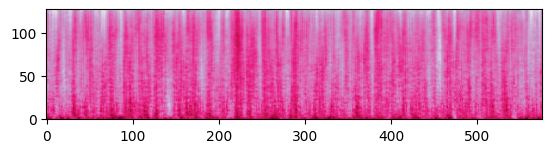

2025-06-02 07:21:54,535 - LIGHT_DEBUG - Normalized to range: [-1,1]


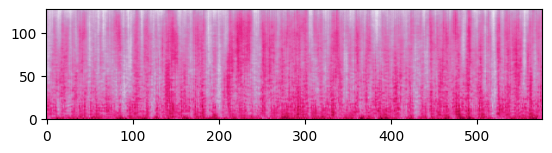

2025-06-02 07:21:54,629 - INFO - Epoch 080: Avg. Loss: 1.09334e-01 Avg. val. Loss: 1.18233e-01 Remaining Time: 01h 24min 19s LR: 9.93244e-05 
2025-06-02 07:21:56,595 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_070.pth deleted
2025-06-02 07:21:56,595 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_080.pth


2025-06-02 07:22:17,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.088 Min/Max params: -2.370, 2.655


2025-06-02 07:22:18,072 - INFO - Epoch 081: Avg. Loss: 1.07367e-01 Avg. val. Loss: 1.13285e-01 Remaining Time: 01h 23min 52s LR: 9.73379e-05 


2025-06-02 07:22:44,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.126 Min/Max params: -2.370, 2.655


2025-06-02 07:22:44,544 - INFO - Epoch 082: Avg. Loss: 1.01957e-01 Avg. val. Loss: 1.16322e-01 Remaining Time: 01h 23min 38s LR: 9.53912e-05 


2025-06-02 07:23:10,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.076 Min/Max params: -2.370, 2.655


2025-06-02 07:23:10,410 - INFO - Epoch 083: Avg. Loss: 1.01320e-01 Avg. val. Loss: 1.15013e-01 Remaining Time: 01h 23min 23s LR: 9.34834e-05 


2025-06-02 07:23:36,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.106 Min/Max params: -2.370, 2.655


2025-06-02 07:23:36,164 - INFO - Epoch 084: Avg. Loss: 1.07939e-01 Avg. val. Loss: 1.25341e-01 Remaining Time: 01h 23min 07s LR: 9.16137e-05 


2025-06-02 07:23:58,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.103 Min/Max params: -2.370, 2.655


2025-06-02 07:23:58,648 - INFO - Epoch 085: Avg. Loss: 1.04872e-01 Avg. val. Loss: 1.02262e-01 Remaining Time: 01h 22min 42s LR: 8.97814e-05 


2025-06-02 07:24:18,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.111 Min/Max params: -2.370, 2.655


2025-06-02 07:24:19,006 - INFO - Epoch 086: Avg. Loss: 1.02867e-01 Avg. val. Loss: 1.01942e-01 Remaining Time: 01h 22min 12s LR: 8.79858e-05 


2025-06-02 07:24:41,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.125 Min/Max params: -2.370, 2.655


2025-06-02 07:24:41,950 - INFO - Epoch 087: Avg. Loss: 1.04628e-01 Avg. val. Loss: 9.87379e-02 Remaining Time: 01h 21min 49s LR: 8.62261e-05 


2025-06-02 07:25:00,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.102 Min/Max params: -2.370, 2.655


2025-06-02 07:25:00,436 - INFO - Epoch 088: Avg. Loss: 1.03186e-01 Avg. val. Loss: 1.01636e-01 Remaining Time: 01h 21min 15s LR: 8.45015e-05 


2025-06-02 07:25:27,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.073 Min/Max params: -2.369, 2.655


2025-06-02 07:25:27,887 - INFO - Epoch 089: Avg. Loss: 1.04241e-01 Avg. val. Loss: 1.13844e-01 Remaining Time: 01h 21min 02s LR: 8.28115e-05 


2025-06-02 07:25:48,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.091 Min/Max params: -2.369, 2.655


2025-06-02 07:25:49,402 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:25:49,408 - LIGHT_DEBUG - Normalized to range: [-1,1]


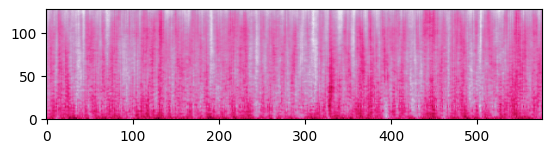

2025-06-02 07:25:49,506 - LIGHT_DEBUG - Normalized to range: [-1,1]


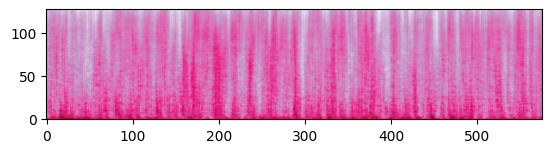

2025-06-02 07:25:49,595 - INFO - Epoch 090: Avg. Loss: 1.00756e-01 Avg. val. Loss: 8.67164e-02 Remaining Time: 01h 20min 36s LR: 8.11553e-05 
2025-06-02 07:25:51,602 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_080.pth deleted
2025-06-02 07:25:51,602 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_090.pth


2025-06-02 07:26:12,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.082 Min/Max params: -2.369, 2.654


2025-06-02 07:26:13,542 - INFO - Epoch 091: Avg. Loss: 1.04071e-01 Avg. val. Loss: 1.13925e-01 Remaining Time: 01h 20min 11s LR: 7.95322e-05 


2025-06-02 07:26:33,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.079 Min/Max params: -2.369, 2.654


2025-06-02 07:26:33,216 - INFO - Epoch 092: Avg. Loss: 1.02215e-01 Avg. val. Loss: 1.02266e-01 Remaining Time: 01h 19min 40s LR: 7.79415e-05 


2025-06-02 07:26:51,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.067 Min/Max params: -2.369, 2.654


2025-06-02 07:26:51,273 - INFO - Epoch 093: Avg. Loss: 1.02513e-01 Avg. val. Loss: 1.26432e-01 Remaining Time: 01h 19min 06s LR: 7.63827e-05 


2025-06-02 07:27:11,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.369, 2.654


2025-06-02 07:27:11,772 - INFO - Epoch 094: Avg. Loss: 1.02828e-01 Avg. val. Loss: 1.20081e-01 Remaining Time: 01h 18min 38s LR: 7.48551e-05 


2025-06-02 07:27:34,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.369, 2.654


2025-06-02 07:27:34,240 - INFO - Epoch 095: Avg. Loss: 1.01199e-01 Avg. val. Loss: 1.24550e-01 Remaining Time: 01h 18min 14s LR: 7.33580e-05 


2025-06-02 07:27:51,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.088 Min/Max params: -2.369, 2.654


2025-06-02 07:27:52,089 - INFO - Epoch 096: Avg. Loss: 1.04445e-01 Avg. val. Loss: 1.04401e-01 Remaining Time: 01h 17min 40s LR: 7.18908e-05 


2025-06-02 07:28:09,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.101 Min/Max params: -2.369, 2.654


2025-06-02 07:28:09,917 - INFO - Epoch 097: Avg. Loss: 1.00400e-01 Avg. val. Loss: 8.91126e-02 Remaining Time: 01h 17min 07s LR: 7.04530e-05 


2025-06-02 07:28:34,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.086 Min/Max params: -2.369, 2.654


2025-06-02 07:28:34,606 - INFO - Epoch 098: Avg. Loss: 1.01305e-01 Avg. val. Loss: 1.17163e-01 Remaining Time: 01h 16min 48s LR: 6.90439e-05 


2025-06-02 07:28:55,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.369, 2.654


2025-06-02 07:28:55,941 - INFO - Epoch 099: Avg. Loss: 1.02897e-01 Avg. val. Loss: 1.30016e-01 Remaining Time: 01h 16min 22s LR: 6.76630e-05 


2025-06-02 07:29:17,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.125 Min/Max params: -2.368, 2.654


2025-06-02 07:29:18,180 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:29:18,187 - LIGHT_DEBUG - Normalized to range: [-1,1]


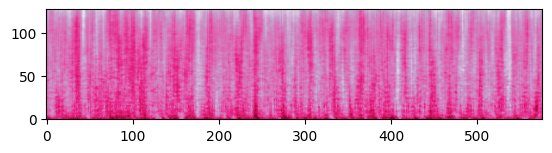

2025-06-02 07:29:18,271 - LIGHT_DEBUG - Normalized to range: [-1,1]


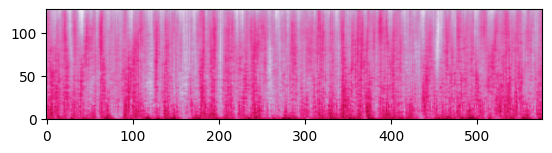

2025-06-02 07:29:18,359 - INFO - Epoch 100: Avg. Loss: 1.04943e-01 Avg. val. Loss: 1.29703e-01 Remaining Time: 01h 15min 59s LR: 6.63098e-05 
2025-06-02 07:29:20,311 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_090.pth deleted
2025-06-02 07:29:20,312 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_100.pth


2025-06-02 07:29:41,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.128 Min/Max params: -2.368, 2.654


2025-06-02 07:29:41,704 - INFO - Epoch 101: Avg. Loss: 1.04875e-01 Avg. val. Loss: 1.20231e-01 Remaining Time: 01h 15min 33s LR: 6.49836e-05 


2025-06-02 07:30:01,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.079 Min/Max params: -2.368, 2.654


2025-06-02 07:30:01,253 - INFO - Epoch 102: Avg. Loss: 9.94117e-02 Avg. val. Loss: 1.23334e-01 Remaining Time: 01h 15min 04s LR: 6.36839e-05 


2025-06-02 07:30:19,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.103 Min/Max params: -2.368, 2.653


2025-06-02 07:30:19,462 - INFO - Epoch 103: Avg. Loss: 9.92063e-02 Avg. val. Loss: 1.25142e-01 Remaining Time: 01h 14min 33s LR: 6.24102e-05 


2025-06-02 07:30:43,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.106 Min/Max params: -2.368, 2.653


2025-06-02 07:30:43,965 - INFO - Epoch 104: Avg. Loss: 1.01636e-01 Avg. val. Loss: 1.03801e-01 Remaining Time: 01h 14min 13s LR: 6.11620e-05 


2025-06-02 07:31:08,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.089 Min/Max params: -2.368, 2.653


2025-06-02 07:31:09,086 - INFO - Epoch 105: Avg. Loss: 9.93493e-02 Avg. val. Loss: 9.01125e-02 Remaining Time: 01h 13min 55s LR: 5.99388e-05 


2025-06-02 07:31:32,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.095 Min/Max params: -2.368, 2.653


2025-06-02 07:31:33,027 - INFO - Epoch 106: Avg. Loss: 1.02987e-01 Avg. val. Loss: 1.15574e-01 Remaining Time: 01h 13min 35s LR: 5.87400e-05 


2025-06-02 07:31:52,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.095 Min/Max params: -2.368, 2.653


2025-06-02 07:31:52,501 - INFO - Epoch 107: Avg. Loss: 1.01348e-01 Avg. val. Loss: 9.53680e-02 Remaining Time: 01h 13min 06s LR: 5.75652e-05 


2025-06-02 07:32:11,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.089 Min/Max params: -2.368, 2.653


2025-06-02 07:32:12,024 - INFO - Epoch 108: Avg. Loss: 9.98540e-02 Avg. val. Loss: 1.00352e-01 Remaining Time: 01h 12min 37s LR: 5.64139e-05 


2025-06-02 07:32:30,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.066 Min/Max params: -2.368, 2.653


2025-06-02 07:32:30,365 - INFO - Epoch 109: Avg. Loss: 9.82746e-02 Avg. val. Loss: 1.05300e-01 Remaining Time: 01h 12min 07s LR: 5.52856e-05 


2025-06-02 07:32:50,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.104 Min/Max params: -2.368, 2.653


2025-06-02 07:32:50,995 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:32:51,001 - LIGHT_DEBUG - Normalized to range: [-1,1]


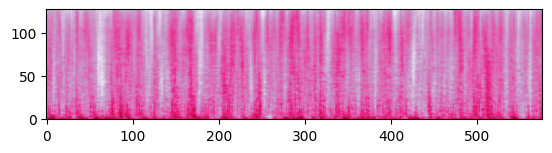

2025-06-02 07:32:51,085 - LIGHT_DEBUG - Normalized to range: [-1,1]


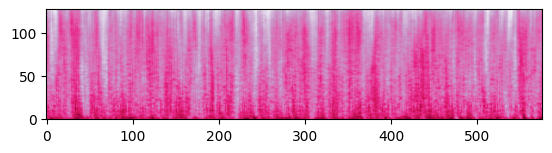

2025-06-02 07:32:51,168 - INFO - Epoch 110: Avg. Loss: 1.01081e-01 Avg. val. Loss: 1.18389e-01 Remaining Time: 01h 11min 41s LR: 5.41799e-05 
2025-06-02 07:32:53,157 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_100.pth deleted
2025-06-02 07:32:53,157 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_110.pth


2025-06-02 07:33:16,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.087 Min/Max params: -2.368, 2.653


2025-06-02 07:33:16,272 - INFO - Epoch 111: Avg. Loss: 9.95216e-02 Avg. val. Loss: 1.12887e-01 Remaining Time: 01h 11min 19s LR: 5.30963e-05 


2025-06-02 07:33:51,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.092 Min/Max params: -2.368, 2.653


2025-06-02 07:33:52,791 - INFO - Epoch 112: Avg. Loss: 1.02071e-01 Avg. val. Loss: 1.06880e-01 Remaining Time: 01h 11min 20s LR: 5.20344e-05 


2025-06-02 07:34:21,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.085 Min/Max params: -2.368, 2.653


2025-06-02 07:34:21,840 - INFO - Epoch 113: Avg. Loss: 1.01521e-01 Avg. val. Loss: 1.00333e-01 Remaining Time: 01h 11min 08s LR: 5.09937e-05 


2025-06-02 07:34:40,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.086 Min/Max params: -2.368, 2.653


2025-06-02 07:34:41,075 - INFO - Epoch 114: Avg. Loss: 9.82162e-02 Avg. val. Loss: 9.97731e-02 Remaining Time: 01h 10min 39s LR: 4.99738e-05 


2025-06-02 07:35:10,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.084 Min/Max params: -2.368, 2.653


2025-06-02 07:35:10,752 - INFO - Epoch 115: Avg. Loss: 9.84966e-02 Avg. val. Loss: 9.65612e-02 Remaining Time: 01h 10min 27s LR: 4.89744e-05 


2025-06-02 07:35:36,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.105 Min/Max params: -2.368, 2.653


2025-06-02 07:35:36,205 - INFO - Epoch 116: Avg. Loss: 9.91884e-02 Avg. val. Loss: 1.09621e-01 Remaining Time: 01h 10min 09s LR: 4.79949e-05 


2025-06-02 07:35:55,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.100 Min/Max params: -2.368, 2.653


2025-06-02 07:35:56,016 - INFO - Epoch 117: Avg. Loss: 9.75061e-02 Avg. val. Loss: 1.48122e-01 Remaining Time: 01h 09min 41s LR: 4.70350e-05 


2025-06-02 07:36:18,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.101 Min/Max params: -2.368, 2.653


2025-06-02 07:36:18,267 - INFO - Epoch 118: Avg. Loss: 9.91148e-02 Avg. val. Loss: 9.42207e-02 Remaining Time: 01h 09min 17s LR: 4.60943e-05 


2025-06-02 07:36:37,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.077 Min/Max params: -2.368, 2.653


2025-06-02 07:36:37,333 - INFO - Epoch 119: Avg. Loss: 1.00908e-01 Avg. val. Loss: 1.02363e-01 Remaining Time: 01h 08min 48s LR: 4.51724e-05 


2025-06-02 07:37:04,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.368, 2.653


2025-06-02 07:37:04,788 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:37:04,795 - LIGHT_DEBUG - Normalized to range: [-1,1]


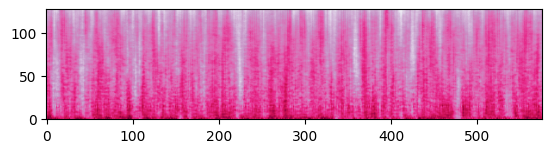

2025-06-02 07:37:04,883 - LIGHT_DEBUG - Normalized to range: [-1,1]


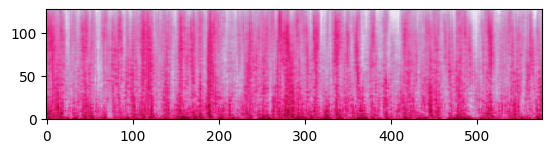

2025-06-02 07:37:04,967 - INFO - Epoch 120: Avg. Loss: 1.02607e-01 Avg. val. Loss: 1.17001e-01 Remaining Time: 01h 08min 33s LR: 4.42689e-05 
2025-06-02 07:37:06,928 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_110.pth deleted
2025-06-02 07:37:06,929 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_120.pth


2025-06-02 07:37:26,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.367, 2.653


2025-06-02 07:37:26,418 - INFO - Epoch 121: Avg. Loss: 9.95642e-02 Avg. val. Loss: 1.14769e-01 Remaining Time: 01h 08min 05s LR: 4.33836e-05 


2025-06-02 07:37:50,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.087 Min/Max params: -2.368, 2.653


2025-06-02 07:37:50,250 - INFO - Epoch 122: Avg. Loss: 9.96092e-02 Avg. val. Loss: 9.16786e-02 Remaining Time: 01h 07min 44s LR: 4.25159e-05 


2025-06-02 07:38:10,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.084 Min/Max params: -2.368, 2.653


2025-06-02 07:38:11,206 - INFO - Epoch 123: Avg. Loss: 9.80958e-02 Avg. val. Loss: 1.31751e-01 Remaining Time: 01h 07min 18s LR: 4.16656e-05 


2025-06-02 07:38:39,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.086 Min/Max params: -2.368, 2.653


2025-06-02 07:38:39,881 - INFO - Epoch 124: Avg. Loss: 1.00402e-01 Avg. val. Loss: 8.17199e-02 Remaining Time: 01h 07min 04s LR: 4.08323e-05 


2025-06-02 07:39:08,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.089 Min/Max params: -2.368, 2.653


2025-06-02 07:39:09,380 - INFO - Epoch 125: Avg. Loss: 9.63702e-02 Avg. val. Loss: 1.05707e-01 Remaining Time: 01h 06min 50s LR: 4.00156e-05 


2025-06-02 07:39:32,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.091 Min/Max params: -2.367, 2.653


2025-06-02 07:39:32,610 - INFO - Epoch 126: Avg. Loss: 9.62961e-02 Avg. val. Loss: 1.37405e-01 Remaining Time: 01h 06min 28s LR: 3.92153e-05 


2025-06-02 07:39:52,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.104 Min/Max params: -2.368, 2.653


2025-06-02 07:39:52,197 - INFO - Epoch 127: Avg. Loss: 9.82118e-02 Avg. val. Loss: 1.07684e-01 Remaining Time: 01h 06min 00s LR: 3.84310e-05 


2025-06-02 07:40:10,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.120 Min/Max params: -2.368, 2.653


2025-06-02 07:40:10,778 - INFO - Epoch 128: Avg. Loss: 9.76076e-02 Avg. val. Loss: 1.26120e-01 Remaining Time: 01h 05min 31s LR: 3.76624e-05 


2025-06-02 07:40:31,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.093 Min/Max params: -2.367, 2.653


2025-06-02 07:40:32,067 - INFO - Epoch 129: Avg. Loss: 1.02635e-01 Avg. val. Loss: 1.32301e-01 Remaining Time: 01h 05min 06s LR: 3.69091e-05 


2025-06-02 07:40:52,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.085 Min/Max params: -2.367, 2.653


2025-06-02 07:40:53,206 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:40:53,213 - LIGHT_DEBUG - Normalized to range: [-1,1]


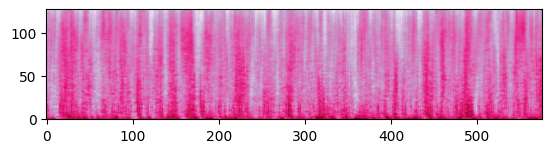

2025-06-02 07:40:53,317 - LIGHT_DEBUG - Normalized to range: [-1,1]


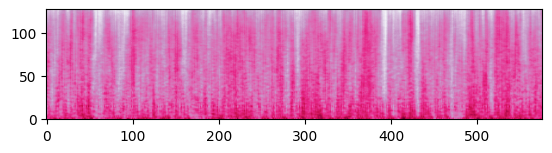

2025-06-02 07:40:53,404 - INFO - Epoch 130: Avg. Loss: 9.49562e-02 Avg. val. Loss: 1.10168e-01 Remaining Time: 01h 04min 42s LR: 3.61709e-05 
2025-06-02 07:40:55,383 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_120.pth deleted
2025-06-02 07:40:55,384 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_130.pth


2025-06-02 07:41:14,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.090 Min/Max params: -2.367, 2.653


2025-06-02 07:41:14,659 - INFO - Epoch 131: Avg. Loss: 9.97211e-02 Avg. val. Loss: 1.05798e-01 Remaining Time: 01h 04min 14s LR: 3.54475e-05 


2025-06-02 07:41:32,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.083 Min/Max params: -2.367, 2.653


2025-06-02 07:41:33,019 - INFO - Epoch 132: Avg. Loss: 1.00439e-01 Avg. val. Loss: 9.34714e-02 Remaining Time: 01h 03min 46s LR: 3.47386e-05 


2025-06-02 07:41:50,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.081 Min/Max params: -2.367, 2.653


2025-06-02 07:41:50,923 - INFO - Epoch 133: Avg. Loss: 9.90489e-02 Avg. val. Loss: 1.33888e-01 Remaining Time: 01h 03min 17s LR: 3.40438e-05 


2025-06-02 07:42:14,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.091 Min/Max params: -2.367, 2.653


2025-06-02 07:42:14,997 - INFO - Epoch 134: Avg. Loss: 9.63279e-02 Avg. val. Loss: 8.49333e-02 Remaining Time: 01h 02min 56s LR: 3.33629e-05 


2025-06-02 07:42:33,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.074 Min/Max params: -2.367, 2.653


2025-06-02 07:42:33,202 - INFO - Epoch 135: Avg. Loss: 9.84315e-02 Avg. val. Loss: 7.37276e-02 Remaining Time: 01h 02min 27s LR: 3.26957e-05 


2025-06-02 07:42:52,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.080 Min/Max params: -2.367, 2.653


2025-06-02 07:42:52,466 - INFO - Epoch 136: Avg. Loss: 9.96882e-02 Avg. val. Loss: 1.08156e-01 Remaining Time: 01h 02min 01s LR: 3.20418e-05 


2025-06-02 07:43:21,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.086 Min/Max params: -2.367, 2.653


2025-06-02 07:43:21,931 - INFO - Epoch 137: Avg. Loss: 9.78948e-02 Avg. val. Loss: 9.72787e-02 Remaining Time: 01h 01min 46s LR: 3.14009e-05 


2025-06-02 07:43:50,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.086 Min/Max params: -2.367, 2.653


2025-06-02 07:43:50,351 - INFO - Epoch 138: Avg. Loss: 9.62238e-02 Avg. val. Loss: 1.34546e-01 Remaining Time: 01h 01min 30s LR: 3.07729e-05 


2025-06-02 07:44:09,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.079 Min/Max params: -2.367, 2.653


2025-06-02 07:44:09,494 - INFO - Epoch 139: Avg. Loss: 9.62618e-02 Avg. val. Loss: 1.31765e-01 Remaining Time: 01h 01min 03s LR: 3.01574e-05 


2025-06-02 07:44:34,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.098 Min/Max params: -2.367, 2.653


2025-06-02 07:44:37,496 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:44:37,502 - LIGHT_DEBUG - Normalized to range: [-1,1]


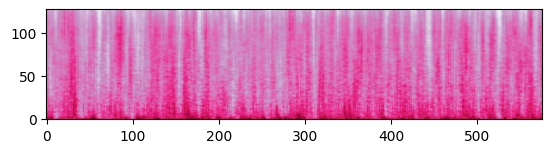

2025-06-02 07:44:37,592 - LIGHT_DEBUG - Normalized to range: [-1,1]


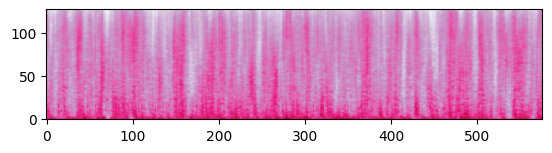

2025-06-02 07:44:37,680 - INFO - Epoch 140: Avg. Loss: 9.99795e-02 Avg. val. Loss: 7.91708e-02 Remaining Time: 01h 00min 46s LR: 2.95543e-05 
2025-06-02 07:44:39,672 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_130.pth deleted
2025-06-02 07:44:39,673 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_140.pth


2025-06-02 07:45:07,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.108 Min/Max params: -2.367, 2.653


2025-06-02 07:45:07,494 - INFO - Epoch 141: Avg. Loss: 9.79621e-02 Avg. val. Loss: 9.26116e-02 Remaining Time: 01h 00min 29s LR: 2.89632e-05 


2025-06-02 07:45:31,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.095 Min/Max params: -2.367, 2.653


2025-06-02 07:45:32,099 - INFO - Epoch 142: Avg. Loss: 9.82107e-02 Avg. val. Loss: 8.65854e-02 Remaining Time: 01h 00min 08s LR: 2.83839e-05 


2025-06-02 07:45:58,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.067 Min/Max params: -2.367, 2.653


2025-06-02 07:45:58,626 - INFO - Epoch 143: Avg. Loss: 9.51065e-02 Avg. val. Loss: 1.04211e-01 Remaining Time: 00h 59min 50s LR: 2.78163e-05 


2025-06-02 07:46:25,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.090 Min/Max params: -2.367, 2.653


2025-06-02 07:46:25,987 - INFO - Epoch 144: Avg. Loss: 9.72185e-02 Avg. val. Loss: 1.08511e-01 Remaining Time: 00h 59min 32s LR: 2.72599e-05 


2025-06-02 07:46:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.092 Min/Max params: -2.367, 2.653


2025-06-02 07:46:47,807 - INFO - Epoch 145: Avg. Loss: 9.68459e-02 Avg. val. Loss: 1.13920e-01 Remaining Time: 00h 59min 08s LR: 2.67147e-05 


2025-06-02 07:47:05,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.367, 2.653


2025-06-02 07:47:06,114 - INFO - Epoch 146: Avg. Loss: 9.79227e-02 Avg. val. Loss: 8.87681e-02 Remaining Time: 00h 58min 40s LR: 2.61804e-05 


2025-06-02 07:47:33,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.083 Min/Max params: -2.367, 2.653


2025-06-02 07:47:33,607 - INFO - Epoch 147: Avg. Loss: 1.00764e-01 Avg. val. Loss: 9.29001e-02 Remaining Time: 00h 58min 22s LR: 2.56568e-05 


2025-06-02 07:47:57,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.093 Min/Max params: -2.367, 2.653


2025-06-02 07:47:57,889 - INFO - Epoch 148: Avg. Loss: 9.92628e-02 Avg. val. Loss: 1.04010e-01 Remaining Time: 00h 58min 00s LR: 2.51437e-05 


2025-06-02 07:48:17,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.075 Min/Max params: -2.367, 2.653


2025-06-02 07:48:18,201 - INFO - Epoch 149: Avg. Loss: 9.89859e-02 Avg. val. Loss: 9.47768e-02 Remaining Time: 00h 57min 35s LR: 2.46408e-05 


2025-06-02 07:48:42,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.106 Min/Max params: -2.367, 2.653


2025-06-02 07:48:42,894 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:48:42,900 - LIGHT_DEBUG - Normalized to range: [-1,1]


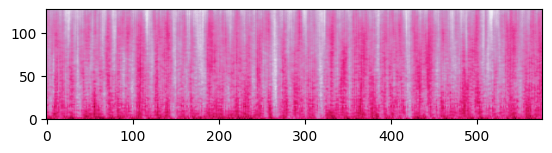

2025-06-02 07:48:42,986 - LIGHT_DEBUG - Normalized to range: [-1,1]


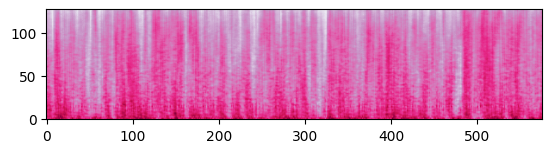

2025-06-02 07:48:43,071 - INFO - Epoch 150: Avg. Loss: 9.90651e-02 Avg. val. Loss: 1.33091e-01 Remaining Time: 00h 57min 14s LR: 2.41480e-05 
2025-06-02 07:48:45,026 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_140.pth deleted
2025-06-02 07:48:45,026 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_150.pth


2025-06-02 07:49:05,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.091 Min/Max params: -2.367, 2.653


2025-06-02 07:49:05,652 - INFO - Epoch 151: Avg. Loss: 9.63606e-02 Avg. val. Loss: 1.25749e-01 Remaining Time: 00h 56min 49s LR: 2.36651e-05 


2025-06-02 07:49:23,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.093 Min/Max params: -2.367, 2.653


2025-06-02 07:49:23,595 - INFO - Epoch 152: Avg. Loss: 9.68503e-02 Avg. val. Loss: 1.33394e-01 Remaining Time: 00h 56min 21s LR: 2.31917e-05 


2025-06-02 07:49:46,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.070 Min/Max params: -2.367, 2.653


2025-06-02 07:49:46,224 - INFO - Epoch 153: Avg. Loss: 9.61215e-02 Avg. val. Loss: 1.04457e-01 Remaining Time: 00h 55min 58s LR: 2.27279e-05 


2025-06-02 07:50:05,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.113 Min/Max params: -2.367, 2.653


2025-06-02 07:50:05,188 - INFO - Epoch 154: Avg. Loss: 9.90579e-02 Avg. val. Loss: 1.06207e-01 Remaining Time: 00h 55min 31s LR: 2.22734e-05 


2025-06-02 07:50:33,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.367, 2.653


2025-06-02 07:50:33,328 - INFO - Epoch 155: Avg. Loss: 9.86938e-02 Avg. val. Loss: 9.69039e-02 Remaining Time: 00h 55min 14s LR: 2.18279e-05 


2025-06-02 07:50:51,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.089 Min/Max params: -2.368, 2.653


2025-06-02 07:50:51,323 - INFO - Epoch 156: Avg. Loss: 9.48151e-02 Avg. val. Loss: 1.09642e-01 Remaining Time: 00h 54min 46s LR: 2.13913e-05 


2025-06-02 07:51:09,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.092 Min/Max params: -2.368, 2.653


2025-06-02 07:51:09,514 - INFO - Epoch 157: Avg. Loss: 9.67120e-02 Avg. val. Loss: 1.08230e-01 Remaining Time: 00h 54min 19s LR: 2.09635e-05 


2025-06-02 07:51:31,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.106 Min/Max params: -2.368, 2.653


2025-06-02 07:51:31,661 - INFO - Epoch 158: Avg. Loss: 9.49708e-02 Avg. val. Loss: 9.87880e-02 Remaining Time: 00h 53min 56s LR: 2.05442e-05 


2025-06-02 07:51:53,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.090 Min/Max params: -2.368, 2.653


2025-06-02 07:51:53,669 - INFO - Epoch 159: Avg. Loss: 1.02061e-01 Avg. val. Loss: 9.08500e-02 Remaining Time: 00h 53min 32s LR: 2.01333e-05 


2025-06-02 07:52:16,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.098 Min/Max params: -2.368, 2.653


2025-06-02 07:52:17,246 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:52:17,253 - LIGHT_DEBUG - Normalized to range: [-1,1]


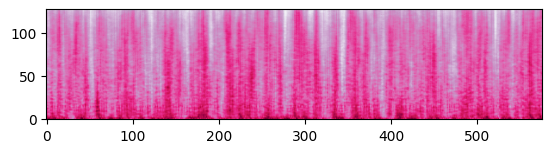

2025-06-02 07:52:17,337 - LIGHT_DEBUG - Normalized to range: [-1,1]


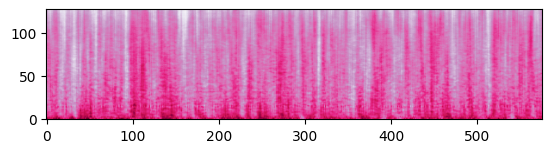

2025-06-02 07:52:17,428 - INFO - Epoch 160: Avg. Loss: 9.73412e-02 Avg. val. Loss: 9.02786e-02 Remaining Time: 00h 53min 10s LR: 1.97307e-05 
2025-06-02 07:52:19,425 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_150.pth deleted
2025-06-02 07:52:19,426 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_160.pth


2025-06-02 07:52:44,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.093 Min/Max params: -2.368, 2.653


2025-06-02 07:52:44,275 - INFO - Epoch 161: Avg. Loss: 9.72065e-02 Avg. val. Loss: 1.21917e-01 Remaining Time: 00h 52min 49s LR: 1.93361e-05 


2025-06-02 07:53:02,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.092 Min/Max params: -2.368, 2.653


2025-06-02 07:53:02,720 - INFO - Epoch 162: Avg. Loss: 9.69200e-02 Avg. val. Loss: 1.09913e-01 Remaining Time: 00h 52min 23s LR: 1.89493e-05 


2025-06-02 07:53:25,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.091 Min/Max params: -2.368, 2.653


2025-06-02 07:53:26,028 - INFO - Epoch 163: Avg. Loss: 9.72644e-02 Avg. val. Loss: 9.55949e-02 Remaining Time: 00h 52min 01s LR: 1.85704e-05 


2025-06-02 07:53:45,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.099 Min/Max params: -2.368, 2.653


2025-06-02 07:53:46,207 - INFO - Epoch 164: Avg. Loss: 9.77146e-02 Avg. val. Loss: 1.00429e-01 Remaining Time: 00h 51min 36s LR: 1.81990e-05 


2025-06-02 07:54:04,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.126 Min/Max params: -2.368, 2.653


2025-06-02 07:54:04,271 - INFO - Epoch 165: Avg. Loss: 9.87380e-02 Avg. val. Loss: 8.06181e-02 Remaining Time: 00h 51min 09s LR: 1.78350e-05 


2025-06-02 07:54:22,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.368, 2.653


2025-06-02 07:54:22,430 - INFO - Epoch 166: Avg. Loss: 9.56166e-02 Avg. val. Loss: 9.25475e-02 Remaining Time: 00h 50min 43s LR: 1.74783e-05 


2025-06-02 07:54:40,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.076 Min/Max params: -2.368, 2.653


2025-06-02 07:54:40,831 - INFO - Epoch 167: Avg. Loss: 9.75243e-02 Avg. val. Loss: 1.26089e-01 Remaining Time: 00h 50min 16s LR: 1.71287e-05 


2025-06-02 07:55:02,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.099 Min/Max params: -2.368, 2.653


2025-06-02 07:55:02,431 - INFO - Epoch 168: Avg. Loss: 9.53240e-02 Avg. val. Loss: 1.32075e-01 Remaining Time: 00h 49min 53s LR: 1.67861e-05 


2025-06-02 07:55:24,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.076 Min/Max params: -2.368, 2.654


2025-06-02 07:55:25,059 - INFO - Epoch 169: Avg. Loss: 9.40107e-02 Avg. val. Loss: 1.16954e-01 Remaining Time: 00h 49min 30s LR: 1.64504e-05 


2025-06-02 07:55:47,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.096 Min/Max params: -2.368, 2.654


2025-06-02 07:55:48,014 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:55:48,021 - LIGHT_DEBUG - Normalized to range: [-1,1]


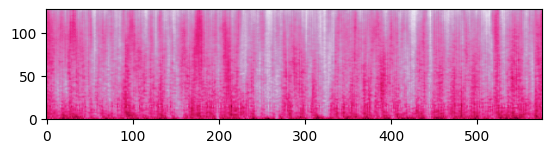

2025-06-02 07:55:48,110 - LIGHT_DEBUG - Normalized to range: [-1,1]


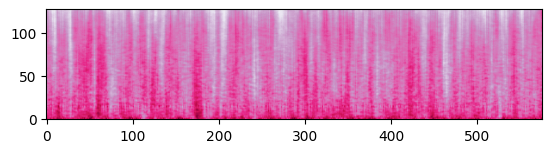

2025-06-02 07:55:48,200 - INFO - Epoch 170: Avg. Loss: 9.63936e-02 Avg. val. Loss: 8.74807e-02 Remaining Time: 00h 49min 08s LR: 1.61214e-05 
2025-06-02 07:55:50,194 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_160.pth deleted
2025-06-02 07:55:50,194 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_170.pth


2025-06-02 07:56:14,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.109 Min/Max params: -2.368, 2.654


2025-06-02 07:56:15,096 - INFO - Epoch 171: Avg. Loss: 9.68284e-02 Avg. val. Loss: 1.00234e-01 Remaining Time: 00h 48min 47s LR: 1.57990e-05 


2025-06-02 07:56:38,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.101 Min/Max params: -2.368, 2.654


2025-06-02 07:56:39,179 - INFO - Epoch 172: Avg. Loss: 9.66402e-02 Avg. val. Loss: 1.17563e-01 Remaining Time: 00h 48min 25s LR: 1.54830e-05 


2025-06-02 07:56:58,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.082 Min/Max params: -2.368, 2.654


2025-06-02 07:56:58,322 - INFO - Epoch 173: Avg. Loss: 9.66470e-02 Avg. val. Loss: 6.68811e-02 Remaining Time: 00h 48min 00s LR: 1.51733e-05 


2025-06-02 07:57:20,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.110 Min/Max params: -2.368, 2.654


2025-06-02 07:57:20,593 - INFO - Epoch 174: Avg. Loss: 9.63700e-02 Avg. val. Loss: 1.32933e-01 Remaining Time: 00h 47min 37s LR: 1.48699e-05 


2025-06-02 07:57:46,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.072 Min/Max params: -2.368, 2.654


2025-06-02 07:57:47,332 - INFO - Epoch 175: Avg. Loss: 9.76918e-02 Avg. val. Loss: 8.94490e-02 Remaining Time: 00h 47min 17s LR: 1.45725e-05 


2025-06-02 07:58:12,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.107 Min/Max params: -2.368, 2.654


2025-06-02 07:58:12,715 - INFO - Epoch 176: Avg. Loss: 9.79327e-02 Avg. val. Loss: 9.42164e-02 Remaining Time: 00h 46min 56s LR: 1.42810e-05 


2025-06-02 07:58:37,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.368, 2.654


2025-06-02 07:58:37,848 - INFO - Epoch 177: Avg. Loss: 1.00091e-01 Avg. val. Loss: 9.03047e-02 Remaining Time: 00h 46min 35s LR: 1.39954e-05 


2025-06-02 07:58:59,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.090 Min/Max params: -2.368, 2.654


2025-06-02 07:58:59,156 - INFO - Epoch 178: Avg. Loss: 9.50435e-02 Avg. val. Loss: 1.05119e-01 Remaining Time: 00h 46min 12s LR: 1.37155e-05 


2025-06-02 07:59:24,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.078 Min/Max params: -2.368, 2.654


2025-06-02 07:59:24,248 - INFO - Epoch 179: Avg. Loss: 9.73858e-02 Avg. val. Loss: 1.13299e-01 Remaining Time: 00h 45min 50s LR: 1.34412e-05 


2025-06-02 07:59:45,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.098 Min/Max params: -2.368, 2.654


2025-06-02 07:59:45,741 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 07:59:45,748 - LIGHT_DEBUG - Normalized to range: [-1,1]


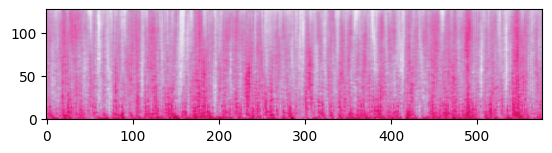

2025-06-02 07:59:45,837 - LIGHT_DEBUG - Normalized to range: [-1,1]


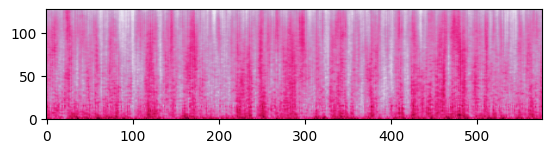

2025-06-02 07:59:45,926 - INFO - Epoch 180: Avg. Loss: 9.78847e-02 Avg. val. Loss: 1.05301e-01 Remaining Time: 00h 45min 27s LR: 1.31724e-05 
2025-06-02 07:59:47,882 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_170.pth deleted
2025-06-02 07:59:47,883 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_180.pth


2025-06-02 08:00:13,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.073 Min/Max params: -2.368, 2.654


2025-06-02 08:00:14,042 - INFO - Epoch 181: Avg. Loss: 9.51777e-02 Avg. val. Loss: 9.04863e-02 Remaining Time: 00h 45min 07s LR: 1.29089e-05 


2025-06-02 08:00:34,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.074 Min/Max params: -2.368, 2.654


2025-06-02 08:00:34,183 - INFO - Epoch 182: Avg. Loss: 9.82314e-02 Avg. val. Loss: 1.03366e-01 Remaining Time: 00h 44min 42s LR: 1.26507e-05 


2025-06-02 08:00:53,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.110 Min/Max params: -2.368, 2.654


2025-06-02 08:00:54,399 - INFO - Epoch 183: Avg. Loss: 9.77999e-02 Avg. val. Loss: 1.33672e-01 Remaining Time: 00h 44min 18s LR: 1.23977e-05 


2025-06-02 08:01:17,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.079 Min/Max params: -2.368, 2.654


2025-06-02 08:01:17,948 - INFO - Epoch 184: Avg. Loss: 9.83794e-02 Avg. val. Loss: 1.03663e-01 Remaining Time: 00h 43min 56s LR: 1.21498e-05 


2025-06-02 08:01:43,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.084 Min/Max params: -2.368, 2.654


2025-06-02 08:01:43,254 - INFO - Epoch 185: Avg. Loss: 9.51272e-02 Avg. val. Loss: 9.72178e-02 Remaining Time: 00h 43min 34s LR: 1.19068e-05 


2025-06-02 08:02:04,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.075 Min/Max params: -2.368, 2.654


2025-06-02 08:02:04,740 - INFO - Epoch 186: Avg. Loss: 9.59031e-02 Avg. val. Loss: 1.12410e-01 Remaining Time: 00h 43min 11s LR: 1.16686e-05 


2025-06-02 08:02:22,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.074 Min/Max params: -2.368, 2.654


2025-06-02 08:02:23,212 - INFO - Epoch 187: Avg. Loss: 9.53274e-02 Avg. val. Loss: 8.97339e-02 Remaining Time: 00h 42min 46s LR: 1.14353e-05 


2025-06-02 08:02:45,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.092 Min/Max params: -2.368, 2.654


2025-06-02 08:02:45,839 - INFO - Epoch 188: Avg. Loss: 9.80477e-02 Avg. val. Loss: 1.19937e-01 Remaining Time: 00h 42min 23s LR: 1.12066e-05 


2025-06-02 08:03:04,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.080 Min/Max params: -2.368, 2.654


2025-06-02 08:03:04,167 - INFO - Epoch 189: Avg. Loss: 9.64373e-02 Avg. val. Loss: 8.34250e-02 Remaining Time: 00h 41min 58s LR: 1.09824e-05 


2025-06-02 08:03:27,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.074 Min/Max params: -2.368, 2.654


2025-06-02 08:03:28,100 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 08:03:28,106 - LIGHT_DEBUG - Normalized to range: [-1,1]


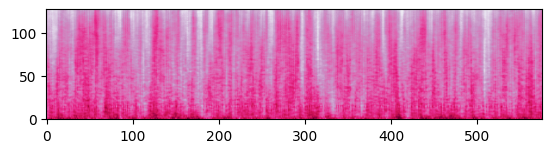

2025-06-02 08:03:28,195 - LIGHT_DEBUG - Normalized to range: [-1,1]


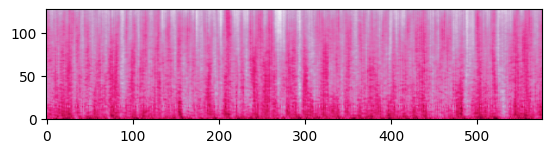

2025-06-02 08:03:28,284 - INFO - Epoch 190: Avg. Loss: 9.62720e-02 Avg. val. Loss: 1.01508e-01 Remaining Time: 00h 41min 36s LR: 1.07628e-05 
2025-06-02 08:03:30,219 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_180.pth deleted
2025-06-02 08:03:30,220 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_190.pth


2025-06-02 08:03:48,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.100 Min/Max params: -2.368, 2.654


2025-06-02 08:03:48,240 - INFO - Epoch 191: Avg. Loss: 9.46556e-02 Avg. val. Loss: 1.34165e-01 Remaining Time: 00h 41min 10s LR: 1.05475e-05 


2025-06-02 08:04:06,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.079 Min/Max params: -2.368, 2.654


2025-06-02 08:04:06,430 - INFO - Epoch 192: Avg. Loss: 9.40443e-02 Avg. val. Loss: 1.01907e-01 Remaining Time: 00h 40min 45s LR: 1.03366e-05 


2025-06-02 08:04:34,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.082 Min/Max params: -2.368, 2.654


2025-06-02 08:04:34,723 - INFO - Epoch 193: Avg. Loss: 9.61732e-02 Avg. val. Loss: 1.10264e-01 Remaining Time: 00h 40min 26s LR: 1.01298e-05 


2025-06-02 08:05:02,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.080 Min/Max params: -2.368, 2.654


2025-06-02 08:05:02,339 - INFO - Epoch 194: Avg. Loss: 9.93970e-02 Avg. val. Loss: 1.43043e-01 Remaining Time: 00h 40min 06s LR: 9.92724e-06 


2025-06-02 08:05:28,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.109 Min/Max params: -2.368, 2.654


2025-06-02 08:05:28,207 - INFO - Epoch 195: Avg. Loss: 9.58051e-02 Avg. val. Loss: 1.21594e-01 Remaining Time: 00h 39min 45s LR: 9.72870e-06 


2025-06-02 08:05:49,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.090 Min/Max params: -2.368, 2.654


2025-06-02 08:05:49,833 - INFO - Epoch 196: Avg. Loss: 9.59591e-02 Avg. val. Loss: 1.03680e-01 Remaining Time: 00h 39min 21s LR: 9.53412e-06 


2025-06-02 08:06:07,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.094 Min/Max params: -2.368, 2.654


2025-06-02 08:06:08,187 - INFO - Epoch 197: Avg. Loss: 9.61235e-02 Avg. val. Loss: 1.28225e-01 Remaining Time: 00h 38min 56s LR: 9.34344e-06 


2025-06-02 08:06:33,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.086 Min/Max params: -2.368, 2.654


2025-06-02 08:06:34,058 - INFO - Epoch 198: Avg. Loss: 9.68688e-02 Avg. val. Loss: 1.20660e-01 Remaining Time: 00h 38min 35s LR: 9.15657e-06 


2025-06-02 08:07:06,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.108 Min/Max params: -2.368, 2.654


2025-06-02 08:07:06,215 - INFO - Epoch 199: Avg. Loss: 9.58662e-02 Avg. val. Loss: 8.08642e-02 Remaining Time: 00h 38min 17s LR: 8.97344e-06 


2025-06-02 08:07:27,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.087 Min/Max params: -2.368, 2.654


2025-06-02 08:07:27,905 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 08:07:27,911 - LIGHT_DEBUG - Normalized to range: [-1,1]


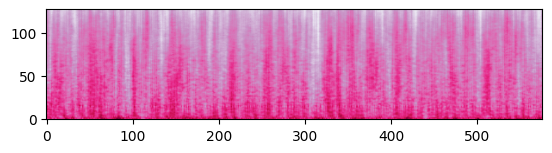

2025-06-02 08:07:28,001 - LIGHT_DEBUG - Normalized to range: [-1,1]


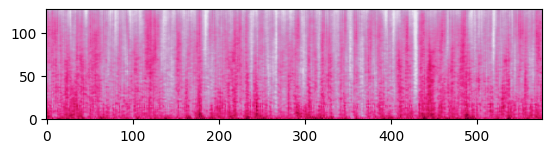

2025-06-02 08:07:28,091 - INFO - Epoch 200: Avg. Loss: 9.69374e-02 Avg. val. Loss: 8.18538e-02 Remaining Time: 00h 37min 54s LR: 8.79397e-06 
2025-06-02 08:07:30,076 - LIGHT_DEBUG - Models/diffusion_full_v15_epoch_190.pth deleted
2025-06-02 08:07:30,077 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_full_v15_epoch_200.pth


2025-06-02 08:07:50,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.117 Min/Max params: -2.368, 2.654


2025-06-02 08:07:51,118 - INFO - Epoch 201: Avg. Loss: 9.97548e-02 Avg. val. Loss: 1.07781e-01 Remaining Time: 00h 37min 31s LR: 8.61809e-06 


2025-06-02 08:08:09,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.081 Min/Max params: -2.368, 2.654


2025-06-02 08:08:09,550 - INFO - Epoch 202: Avg. Loss: 9.62374e-02 Avg. val. Loss: 1.25866e-01 Remaining Time: 00h 37min 06s LR: 8.44573e-06 


2025-06-02 08:08:30,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.080 Min/Max params: -2.368, 2.654


2025-06-02 08:08:30,455 - INFO - Epoch 203: Avg. Loss: 9.44616e-02 Avg. val. Loss: 1.07659e-01 Remaining Time: 00h 36min 42s LR: 8.27682e-06 


2025-06-02 08:08:48,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.090 Min/Max params: -2.368, 2.654


2025-06-02 08:08:48,843 - INFO - Epoch 204: Avg. Loss: 9.70183e-02 Avg. val. Loss: 7.04842e-02 Remaining Time: 00h 36min 18s LR: 8.11128e-06 


2025-06-02 08:09:06,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.099 Min/Max params: -2.368, 2.654


2025-06-02 08:09:06,940 - INFO - Epoch 205: Avg. Loss: 9.58975e-02 Avg. val. Loss: 8.53076e-02 Remaining Time: 00h 35min 53s LR: 7.94906e-06 


2025-06-02 08:09:25,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.087 Min/Max params: -2.368, 2.654


2025-06-02 08:09:25,456 - INFO - Epoch 206: Avg. Loss: 9.41243e-02 Avg. val. Loss: 1.03159e-01 Remaining Time: 00h 35min 28s LR: 7.79007e-06 


2025-06-02 08:09:44,000 - LIGHT_DEBUG - Batch 044/044 Loss: 0.073 Min/Max params: -2.368, 2.654


2025-06-02 08:09:44,984 - INFO - Epoch 207: Avg. Loss: 9.78546e-02 Avg. val. Loss: 9.39963e-02 Remaining Time: 00h 35min 04s LR: 7.63427e-06 


2025-06-02 08:09:54,000 - LIGHT_DEBUG - Batch 022/044 Loss: 0.105 Min/Max params: -2.368, 2.654

KeyboardInterrupt: 

In [20]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=epochs,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=10,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

Save Model Architecture

In [12]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

/usr/local/lib/python3.11/dist-packages/einops/packing.py:148: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  lengths_of_composed_axes: List[int] = [-1 if -1 in p_shape else prod(p_shape) for p_shape in packed_shapes]
/usr/local/lib/python3.11/dist-packages/einops/packing.py:150: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  n_unknown_composed_axes = sum(int(x == -1) for x in lengths_of_composed_axes)


### Sample

2025-06-02 06:30:40,823 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-02 06:30:40,829 - LIGHT_DEBUG - Normalized to range: [-1,1]


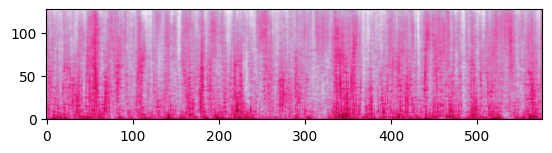

2025-06-02 06:30:40,946 - LIGHT_DEBUG - Normalized to range: [-1,1]


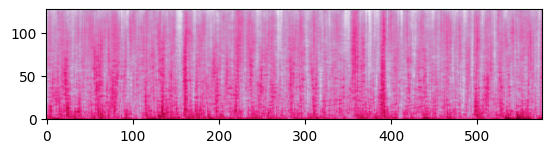

2025-06-02 06:30:41,042 - LIGHT_DEBUG - Normalized to range: [-1,1]


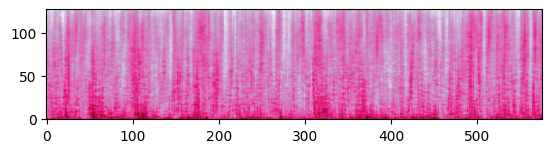

2025-06-02 06:30:41,126 - LIGHT_DEBUG - Normalized to range: [-1,1]


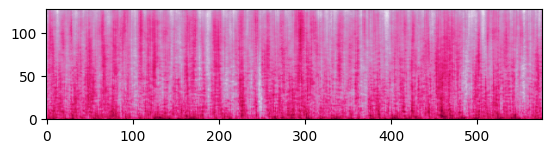

2025-06-02 06:30:41,214 - LIGHT_DEBUG - Normalized to range: [-1,1]


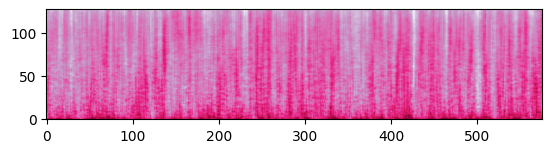

2025-06-02 06:30:41,299 - LIGHT_DEBUG - Normalized to range: [-1,1]


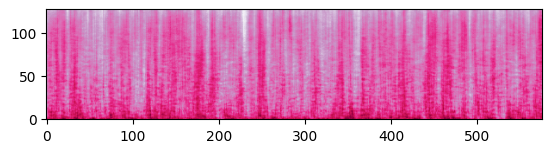

2025-06-02 06:30:41,381 - LIGHT_DEBUG - Normalized to range: [-1,1]


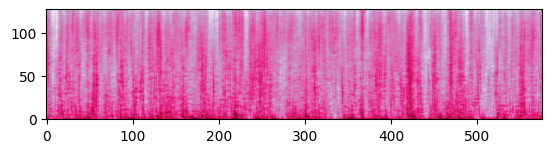

2025-06-02 06:30:41,477 - LIGHT_DEBUG - Normalized to range: [-1,1]


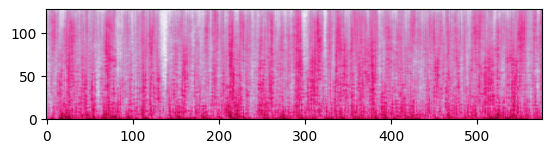

In [9]:
samples = trainer.sample(8, tensor_dim, 100, True)

Save Samples

In [14]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

2025-06-01 19:17:45,035 - LIGHT_DEBUG - Unnormalized to range: [-50,50]
2025-06-01 19:17:45,036 - LIGHT_DEBUG - Started GL
2025-06-01 19:17:58,353 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,354 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-01 19:17:58,355 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,368 - LIGHT_DEBUG - Saved file to:Results/model_result_00.wav
2025-06-01 19:17:58,369 - LIGHT_DEBUG - Unnormalized to range: [-50,50]
2025-06-01 19:17:58,369 - LIGHT_DEBUG - Started GL
2025-06-01 19:17:58,604 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,604 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-01 19:17:58,605 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-01 19:17:58,618 - LIGHT_DEBUG - Saved file to:Results/model_result_01.wav
2025-06-01 19:17:58,619 - LIGHT_DEBUG - Unnormalized to range: [-50,50]
2025-06-01 19:17:58,619 - LIGHT_DEBUG - Started GL
2025-

Evaluate

In [10]:
trainer.get_audio_metrics(samples, file)

2025-06-02 06:30:53,439 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:05,811 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:05,811 - LIGHT_DEBUG - Reconstructed audio: (165600,)
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=576
  warnings.warn(
2025-06-02 06:31:06,774 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:07,001 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:07,002 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-02 06:31:07,010 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:07,236 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:07,236 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-02 06:31:07,245 - LIGHT_DEBUG - Started GL
2025-06-02 06:31:07,478 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-02 06:31:07,479 - LIGHT_DEBUG - Reconstructed audio: (165600,)
2025-06-02 06:31:07,487 - LIGHT_DEBUG

Spectral Convergence Samples/Real: 11.805, 7.797 Spectral Centroid Samples/Real: 4368.292 Hz, 2604.709 Hz
